In [1]:
!pip install -q flwr[simulation] deepbrain 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 25.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.6/677.6 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 37.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you

In [2]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.common import (
    Code, EvaluateIns, EvaluateRes, FitIns, FitRes, GetParametersIns, GetParametersRes,
    Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

2025-06-01 18:09:17.191405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748801357.371006      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748801357.429759      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

# Định nghĩa drop out
class CustomCode(IntEnum):
    DROPPED_OUT = 100

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1+cu124


In [4]:
NUM_CLIENTS = 10
NUM_ROUNDS = 30
DROPOUT = 0.0
BATCHSIZE = 128
OVERLAP = 0.6
LR = 0.1
epochs_round = 1

In [5]:
data_dir = '/kaggle/input/mri-dataset/datasetzip/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [6]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

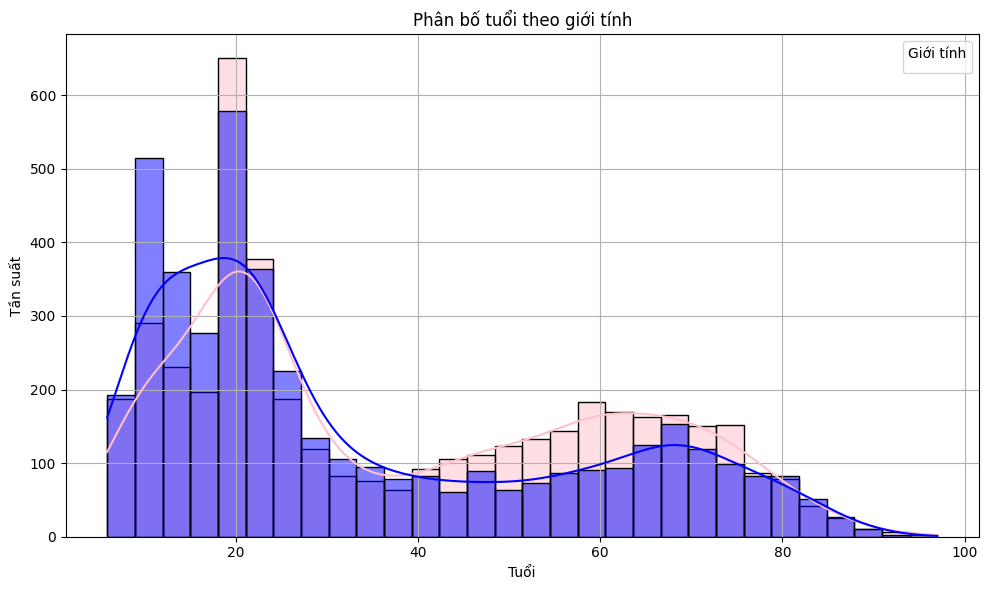

In [7]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')
label_ls = label_ls.dropna(subset=['subject_age'])

plt.figure(figsize=(10, 6))

sns.histplot(data=label_ls, x="subject_age", hue="subject_sex", bins=30, kde=True, 
             palette={"m": "blue", "f": "pink"}, edgecolor="black", discrete=False)

plt.title('Phân bố tuổi theo giới tính')
plt.xlabel('Tuổi')
plt.ylabel('Tần suất')
plt.legend(title='Giới tính')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20.0
...,...,...,...,...
23209,f,sub-BrainAge023209,RocklandSample,66.0
23210,m,sub-BrainAge023210,RocklandSample,69.0
23211,m,sub-BrainAge023211,RocklandSample,23.0
23212,f,sub-BrainAge023212,RocklandSample,54.0


In [9]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

8717

In [10]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        mid_slice = im.shape[2] // 2
        im_slice = im[:, :, mid_slice]
        
        image_2d = np.stack([im_slice]*3, axis=0)
        image_tensor = torch.from_numpy(image_2d).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        label = self._get_label(subject_id)
        return image_tensor, torch.tensor(label, dtype=torch.float32)

In [11]:
def create_global_bin_pool(data: MRIDataset) -> dict:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array([
        subject_metadata.get(sid, {}).get("subject_age", np.nan)
        for sid in subject_ids
    ], dtype=np.float32)

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)

    global_bin_pool = {}
    for bin_id in np.unique(age_bins):
        bin_indices = valid_indices[age_bins == bin_id]
        global_bin_pool[bin_id] = set(bin_indices.tolist())

    return global_bin_pool


def get_sample_data(
    data: MRIDataset,
    overlap: float,
    partition_id: int,
    num_partitions: int,
    global_bin_pool: dict,
    num_samples: int = None,
) -> list:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array(
        [subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
        dtype=np.float32
    )

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)
    total_samples = len(valid_indices)
    client_sample_count = total_samples // num_partitions

    rng = np.random.default_rng(seed=partition_id + 42)
    sampled_indices = set()
    used_bins = set()

    all_bins = list(global_bin_pool.keys())
    rng.shuffle(all_bins)
    target_num_bins = max(1, int(overlap * len(all_bins)))

    # Vòng lặp đến khi đủ sample
    while len(sampled_indices) < client_sample_count:
        # Chọn bin chưa dùng
        candidate_bins = [b for b in all_bins if b not in used_bins]
        if not candidate_bins:
            break  # Không còn bin nào để lấy

        selected_bins = candidate_bins[:target_num_bins]
        used_bins.update(selected_bins)

        # Lấy toàn bộ samples từ các bin đã chọn
        combined_indices = []
        for bin_id in selected_bins:
            available = global_bin_pool[bin_id]
            combined_indices.extend(list(available))

        rng.shuffle(combined_indices)

        # Chọn mẫu đến khi đủ
        needed = client_sample_count - len(sampled_indices)
        to_take = combined_indices[:needed]
        sampled_indices.update(to_take)

        # Xoá mẫu đã chọn khỏi global_bin_pool
        for idx in to_take:
            for bin_id in selected_bins:
                global_bin_pool[bin_id].discard(idx)

    if num_samples and num_samples > client_sample_count:
        remaining_needed = num_samples - client_sample_count
        remaining_pool = list(set(valid_indices) - sampled_indices)
        rng.shuffle(remaining_pool)
        extra = remaining_pool[:remaining_needed]
        sampled_indices.update(extra)

    return list(sampled_indices)

In [12]:
def load_client_datasets(partition_id: int, num_partitions: int, dataset, overlap: int, global_bin_pool: dict, num_samples=None):
    data = dataset
    sampled_indices = get_sample_data(data=data, overlap=overlap, partition_id=partition_id, num_partitions=num_partitions, 
                                      global_bin_pool=global_bin_pool, num_samples=num_samples)

    np.random.shuffle(sampled_indices)
    train_size = int(0.8 * len(sampled_indices))
    train_indices = sampled_indices[:train_size]
    val_indices = sampled_indices[train_size:]

    train_subset = Subset(data, train_indices)
    val_subset = Subset(data, val_indices)
    return train_subset, val_subset

In [13]:
def load_server_test_datasets(data: MRIDataset):
    testloader = DataLoader(data, batch_size=8, shuffle=False)
    return testloader

In [14]:
import json

def load_filenames(input_path):
    input_path = Path(input_path)
    if not input_path.is_file():
        raise FileNotFoundError(f"File {input_path} không tồn tại")
    with open(input_path, 'r') as f:
        return [Path(path) for path in json.load(f)]

In [15]:
im_filenames = load_filenames("/kaggle/input/mri-dataset/mri_dataset.json")

In [16]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames = im_filenames)
len(dataset)

4948

In [17]:
def save_filenames(im_filenames, output_path):
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump([str(path) for path in im_filenames], f)
    print(f"Đã lưu im_filenames vào: {output_path}")

In [18]:
from sklearn.model_selection import train_test_split

all_filenames = dataset.im_filenames

# Chia train/test 
train_filenames, test_filenames = train_test_split(
    all_filenames, test_size=0.2, random_state=42, shuffle=True
)

trainset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=train_filenames
)

testset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=test_filenames
)

In [19]:
from typing import List, Dict, Tuple, Optional, Union
import torch.nn as nn 
#import hydra 
from omegaconf import DictConfig, OmegaConf
import logging 
import wandb 
import os 
import warnings
#import lightning as pl 

In [20]:
global_bin_pool = create_global_bin_pool(trainset)

In [21]:


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module(
            'conv1',
            nn.Conv3d(num_input_features,
                      bn_size * growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module(
            'conv2',
            nn.Conv3d(bn_size * growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super().forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features,
                                     p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                                growth_rate, bn_size, drop_rate)
            self.add_module('denselayer{}'.format(i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module(
            'conv',
            nn.Conv3d(num_input_features,
                      num_output_features,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
    def __init__(self,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=1):
        super().__init__()

        # First convolution
        self.features = [('conv1',
                          nn.Conv3d(n_input_channels,
                                    num_init_features,
                                    kernel_size=(conv1_t_size, 7, 7),
                                    stride=(conv1_t_stride, 2, 2),
                                    padding=(conv1_t_size // 2, 3, 3),
                                    bias=False)),
                         ('norm1', nn.BatchNorm3d(num_init_features)),
                         ('relu1', nn.ReLU(inplace=True))]
        if not no_max_pool:
            self.features.append(
                ('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
        self.features = nn.Sequential(OrderedDict(self.features))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers,
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock{}'.format(i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition{}'.format(i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Khởi tạo trọng số
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out, output_size=(1, 1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out



In [22]:
from torchsummary import summary

In [23]:
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12)).cuda()
summary(model, input_size=(1, 130, 130, 130))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 32, 130, 65, 65]          10,976
       BatchNorm3d-2      [-1, 32, 130, 65, 65]              64
              ReLU-3      [-1, 32, 130, 65, 65]               0
         MaxPool3d-4       [-1, 32, 65, 33, 33]               0
       BatchNorm3d-5       [-1, 32, 65, 33, 33]              64
              ReLU-6       [-1, 32, 65, 33, 33]               0
            Conv3d-7       [-1, 64, 65, 33, 33]           2,048
       BatchNorm3d-8       [-1, 64, 65, 33, 33]             128
              ReLU-9       [-1, 64, 65, 33, 33]               0
           Conv3d-10       [-1, 16, 65, 33, 33]          27,648
      BatchNorm3d-11       [-1, 48, 65, 33, 33]              96
             ReLU-12       [-1, 48, 65, 33, 33]               0
           Conv3d-13       [-1, 64, 65, 33, 33]           3,072
      BatchNorm3d-14       [-1, 64, 65,

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models

class BrainMRINet(nn.Module):
    def __init__(self, num_classes: int = 1, pretrained: bool = True):
        super(BrainMRINet, self).__init__()
        # Load DenseNet-121
        densenet = models.densenet121(weights='IMAGENET1K_V1')

        # Replace the classifier (classifier is a single Linear layer in DenseNet)
        num_features = densenet.classifier.in_features
        densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self.model = densenet

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


In [25]:
from torchinfo import summary

In [26]:
model = BrainMRINet().to(DEVICE)
summary(model, input_size=(1, 3, 130, 130))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 158MB/s] 


Layer (type:depth-idx)                        Output Shape              Param #
BrainMRINet                                   [1, 1]                    --
├─DenseNet: 1-1                               [1, 1]                    --
│    └─Sequential: 2-1                        [1, 1024, 4, 4]           --
│    │    └─Conv2d: 3-1                       [1, 64, 65, 65]           9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 65, 65]           128
│    │    └─ReLU: 3-3                         [1, 64, 65, 65]           --
│    │    └─MaxPool2d: 3-4                    [1, 64, 33, 33]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 33, 33]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 16, 16]          33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 16, 16]          919,680
│    │    └─_Transition: 3-8                  [1, 256, 8, 8]            132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 8, 8]           

In [27]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def save_model_parameters(parameters, file_path: str = "ckpt.pth"):
    if parameters is None:
        print("No parameters available to save.")
        return
    net = model.to(DEVICE)
    final_ndarrays = parameters_to_ndarrays(parameters)
    set_parameters(net, final_ndarrays)
    torch.save(net.state_dict(), file_path)
    print(f"Model parameters saved to {file_path}")


def train(net, trainloader, epochs: int, lr: float, id: int) -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-2)
    net.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).float()
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item())
        
        avg_epoch_loss = epoch_loss / len(trainloader.dataset)
        print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}")
        total_loss += epoch_loss
    
    avg_loss = total_loss / (len(trainloader.dataset) * epochs)
    accuracy = correct / total if total > 0 else 0.0
    print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

def test(net, testloader, id: int, server_test=False) -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    net.eval()
    loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).float()
            outputs = net(images)
            loss += criterion(outputs, labels.unsqueeze(1)).item() * labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            progress_bar.set_postfix(loss=loss/total)
    
    avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    if server_test:
        print(f"[Server Test] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    else:
        print(f"[Client {id}] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

In [28]:
def is_dropout(partition_id: int, num_partitions: int) -> bool:
    return random.random() < DROPOUT

# Định nghĩa Client
class FlowerClient(Client):
    def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_partitions = num_partitions
        self.previous_parameters = None

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.partition_id}] get_parameters")
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(status=status, parameters=parameters)

    def fit(self, ins: FitIns) -> FitRes:
        #if is_dropout(self.partition_id, self.num_partitions):
        #    print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
        #    status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
        #    return FitRes(
        #        status=status,
        #        parameters=ins.parameters,
        #        num_examples=0,
        #        metrics={}
        #    )
        print(f"[Client {self.partition_id}] fit, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        lr = ins.config.get("lr", 0.01)
        epochs = ins.config.get("epochs", 1)
        train_loss, train_accuracy = train(self.net, self.trainloader, epochs=epochs, lr=lr, id=self.partition_id)

        ndarrays_updated = get_parameters(self.net)
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)
        self.previous_parameters = parameters_updated

        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader.dataset),
            metrics={
                "train_loss": float(train_loss),
                "train_accuracy": float(train_accuracy)
            }
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        #if is_dropout(self.partition_id, self.num_partitions):
        #    print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
        #    status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
        #    return EvaluateRes(
        #        status=status,
        #        loss=0.0,
        #        num_examples=0,
        #        metrics={}
        #    )

        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(val_loss),
            num_examples=len(self.valloader.dataset),
            metrics={"val_accuracy": float(val_accuracy)}
        )

# Hàm tạo client
def client_fn(context: Context) -> Client:
    net = model.to(DEVICE)
    partition_id = int(context.node_config["partition-id"])
    num_partitions = context.node_config["num-partitions"]
    
    train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
    trainloader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False)
    
    return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()

# Client
client = ClientApp(client_fn=client_fn)

In [29]:
config={
    "num_client": NUM_CLIENTS,
    "num_rounds": NUM_ROUNDS,
    "dropout": DROPOUT,
    "learning_rate": LR,
    "architecture": "2DNet",
    "dataset": "Mri",
    "epochs_round": epochs_round,
    "overlap": OVERLAP,
}
print(config)


{'num_client': 10, 'num_rounds': 30, 'dropout': 0.0, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}


In [30]:
class FedAR(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0 - DROPOUT,
        fraction_evaluate: float = 1.0 - DROPOUT,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 1,
        evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None,
        eta: float = LR, 
        rho: float = 0.1,
        t0: float = 5.0,  
        b: float = 5.0,
        initial_parameters: Optional[Parameters] = None,
    ):
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.eta = eta
        self.rho = rho
        self.t0 = t0
        self.b = b

        self.G: dict[str, list[np.ndarray]] = {}  # Surrogate updates
        self.tau: dict[str, int] = {}             # Inactivity counters
        self.psi: dict[str, float] = {}           # Staleness weights
        self.E: set[str] = set()                  # Ever-active clients
        self.initialized = False                  # Track if G is initialized
        self.current_params = initial_parameters

    def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
        net = model
        current_params = get_parameters(net)
        return ndarrays_to_parameters(current_params)

    def initialize_state(self, parameters: Parameters):
        """Initialize surrogates to zero for all clients in E."""
        if self.initialized: 
            return
        w_global = parameters_to_ndarrays(parameters)
        for cid in self.E:
            if cid not in self.G:  # Initialize new clients
                self.G[cid] = [np.zeros_like(arr, dtype=np.float32) for arr in w_global]
                self.tau[cid] = 0  # Reset inactivity counter
                self.psi[cid] = 1.0  # Default weight for active client
        self.initialized = True

    def num_fit_clients(self, num_available_clients: int) -> tuple[int, int]:
        """Return the sample size and the required number of available clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

    
    
    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        standard_config = {"lr": LR,
                           "epochs": epochs_round,
                           "server_round": server_round}
        fit_configurations = []
        self.current_params = parameters
        for client in client_manager.all().values():
            cid = client.cid
            if cid not in self.E:
                self.E.add(cid)
        self.initialize_state(parameters)
        
        for client in clients:
            fit_configurations.append((client, FitIns(self.current_params, standard_config)))
        return fit_configurations

    def g(self, server_round: int):
        return self.t0 + server_round/self.b 
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            return None, {}

        #valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
        #if not valid_results:
        #    return None, {}

        g_t = self.g(server_round)
        w_global = parameters_to_ndarrays(self.current_params)
        updated_cids = set()
        for client, fit_res in results:
            cid = client.cid
            w_client = parameters_to_ndarrays(fit_res.parameters)
            self.G[cid] = [
                (w_g - w_c) / self.eta 
                for w_g, w_c in zip(w_global, w_client)
            ]
            self.tau[cid] = 0     # Reset inactivity counter (Eq. 5)
            self.psi[cid] = 1.0   # Active clients: ψ=1 (Eq. 6)
            updated_cids.add(cid)
        print(len(updated_cids))
            
        for cid in self.E:
            if cid not in updated_cids:
                self.tau[cid] += 1
                
        for cid in self.E:
            tau_val = self.tau[cid]
            if tau_val >= g_t:  # Exclude stale clients
                self.psi[cid] = 0.0
            else:
                # ψ = min( (τ+1)^ρ, ψ_max )
                self.psi[cid] = min((tau_val + 1) ** self.rho, 2)
                
        contributing_cids = [client.cid for client, _ in results]
        N_t = len(contributing_cids)
        if N_t == 0:
            return None, {}

        weighted_update = None
        for cid in contributing_cids:
            psi_i = self.psi[cid]
            update_i = [psi_i * g_arr for g_arr in self.G[cid]]
            if weighted_update is None:
                weighted_update = update_i
            else:
                weighted_update = [
                    w_u + u_i for w_u, u_i in zip(weighted_update, update_i)
                ]
        avg_update = [arr / N_t for arr in weighted_update]

        new_weights = [
            w_global[i] - self.eta * avg_update[i]
            for i in range(len(w_global))
        ]
        parameters_aggregated = ndarrays_to_parameters(new_weights)
        self.current_params = parameters_aggregated

        # save model
        if wandb_log:
            if server_round % 2 == 0:
                save_model_parameters(parameters_aggregated, file_path="final_model.pth")

        total_examples = sum(res.num_examples for _, res in results)
        train_loss_agg = sum(
            res.num_examples * res.metrics["train_loss"] for _, res in results
        ) / total_examples if total_examples > 0 else 0.0
        train_accuracy_agg = sum(
            res.num_examples * res.metrics["train_accuracy"] for _, res in results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "train_loss": train_loss_agg,
            "train_accuracy": train_accuracy_agg,
            "clients_participated": len(results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "train_loss": train_loss_agg,
                "train_accuracy": train_accuracy_agg,
                "clients_participated_fit": len(results)
            })

        HISTORY["train_loss"].append(train_loss_agg)
        HISTORY["train_accuracy"].append(train_accuracy_agg)
        HISTORY["clients_participated_fit"].append(len(results))

        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        config = {"server_round": server_round}
        evaluate_ins = EvaluateIns(parameters, config)
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            print(f"Round {server_round}: No results received")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        #valid_results = [
        #    (client_proxy, res) for client_proxy, res in results
        #    if res.status.code == Code.OK
        #]
        #if not valid_results:
        #    print(f"Round {server_round}: No valid evaluation results")
        #    return None, {"val_accuracy": 0.0, "clients_participated": 0}

        total_examples = sum(res.num_examples for _, res in results)
        loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
            [(res.num_examples, res.loss) for _, res in results]
        )
        val_accuracy_aggregated = sum(
            res.num_examples * res.metrics["val_accuracy"] for _, res in results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "val_loss": loss_aggregated,
            "val_accuracy": val_accuracy_aggregated,
            "clients_participated": len(results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "val_loss": loss_aggregated,
                "val_accuracy": val_accuracy_aggregated,
                "clients_participated_eval": len(results)
            })

        HISTORY["val_loss"].append(loss_aggregated)
        HISTORY["val_accuracy"].append(val_accuracy_aggregated)
        HISTORY["clients_participated_eval"].append(len(results))

        return loss_aggregated, metrics_aggregated

    def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if server_round == 0 or self.evaluate_fn is None:
            return None
        parameters_ndarrays = parameters_to_ndarrays(self.current_params)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        return eval_res

    #def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
    #    num_clients = int(num_available_clients * self.fraction_fit)
    #    return max(num_clients, self.min_fit_clients), self.min_available_clients

    #def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
    #    num_clients = int(num_available_clients * self.fraction_evaluate)
    #    return max(num_clients, self.min_evaluate_clients), self.min_available_clients

# Hàm đánh giá trên server
def evaluate_fn(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = model.to(DEVICE)
    set_parameters(net, parameters)
    testloader = load_server_test_datasets(data=testset)
    test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

    if wandb_log:
        wandb_logger.log({
            "round": server_round,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        })
    
    HISTORY["test_loss"].append(test_loss)
    HISTORY["test_accuracy"].append(test_accuracy)
    
    return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAR(
        evaluate_fn=evaluate_fn
    )
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [31]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb api key")
wandb.login(key=wandb_api_key)
wandb_log = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sang2222004 (sang2222004-uet-vnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [32]:
import time

if wandb_log:
    current_time = time.strftime("%Y-%m-%d_%H-%M-%S")
    wandb_logger = wandb.init(
        project="sex-classification",
        name=f"{current_time} + 0.7",
        tags = ['300-samples','TrungNet', 'fedar'],
        config={
            "num_client": NUM_CLIENTS,
            "num_rounds": NUM_ROUNDS,
            "dropout": DROPOUT,
            "learning_rate": LR,
            "architecture": "BrainMRINet",
            "dataset": "mri",
            "epochs_round": epochs_round,
        },
    )

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [33]:
import logging
import absl.logging

logging.basicConfig(level=logging.INFO)
absl.logging.set_verbosity(absl.logging.INFO)

# Cấu hình backend
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1

model = BrainMRINet()
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# Khởi tạo HISTORY
HISTORY = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "clients_participated_fit": [],
    "clients_participated_eval": []
}

# Chạy simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

if wandb_log:
    wandb_logger.finish()

INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=406) 2025-06-01 18:09:54.497512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=406) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=406) E0000 00:00:1748801394.520572     406 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=406) E0000 00:00:1748801394.527439     406 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attem

(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.6766
(ClientAppActor pid=406) [Client 0] Train Loss: 0.6766 | Accuracy: 58.54%
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=406) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=406) [Client 2] Epoch 1/1 - Loss: 0.6729 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=406) [Client 2] Train Loss: 0.6729 | Accuracy: 61.08% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (1, 0.7131642695629236, {'test_accuracy': 0.5606060606060606}, 258.60599760699995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.7132 | Accuracy: 56.06%
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 1}
(ClientAppActor pid=407) [Client 5] Epoch 1/1 - Loss: 0.6803
(ClientAppActor pid=407) [Client 5] Train Loss: 0.6803 | Accuracy: 56.01%
(ClientAppActor pid=406) [Client 2] Test Loss: 0.6861 | Accuracy: 59.49%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 1} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] Test Loss: 0.7445 | Accuracy: 51.90% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 1}
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 1}
(ClientAppActor pid=407) [Client 6] Test Loss: 0.7371 | Accuracy: 53.16% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 8] evaluate, config: {'server_round': 1} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 9] Test Loss: 0.6633 | Accuracy: 63.29% [repeated 2x across cluster]
(Client

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 0] Test Loss: 0.7426 | Accuracy: 51.90% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 0] evaluate, config: {'server_round': 1}
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.6141
(ClientAppActor pid=407) [Client 0] Train Loss: 0.6141 | Accuracy: 62.03%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.5637 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] Train Loss: 0.5637 | Accuracy: 67.41% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=406) [Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=406) [Client 5] Epoch 1/1 - Loss: 0.5751
(ClientAppActor pid=406) [Client 5] Train Loss: 0.5751 | Accuracy: 68.67%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (2, 0.6323457253099692, {'test_accuracy': 0.5767676767676768}, 469.129527984)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6323 | Accuracy: 57.68%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 2}
(ClientAppActor pid=406) [Client 0] Test Loss: 0.6585 | Accuracy: 60.76%
(ClientAppActor pid=407) [Client 1] evaluate, config: {'server_round': 2}
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 2}
(ClientAppActor pid=406) [Client 3] Test Loss: 0.6819 | Accuracy: 48.10% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 9] evaluate, config: {'server_round': 2} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 4] Test Loss: 0.5756 | Accuracy: 70.89% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 8] evaluate, config: {'server_round': 2} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=406) [Client 2] Test Loss: 0.6465 | Accuracy: 53.16% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 2} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.4940
(ClientAppActor pid=407) [Client 2] Train Loss: 0.4940 | Accuracy: 77.85%
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=407) [Client 4] Epoch 1/1 - Loss: 0.4834 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] Train Loss: 0.4834 | Accuracy: 78.48% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=407) [Client 6] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 3}
(C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=407) [Client 3] Epoch 1/1 - Loss: 0.4839
(ClientAppActor pid=407) [Client 3] Train Loss: 0.4839 | Accuracy: 76.90%
10


INFO :      fit progress: (3, 0.625076143789773, {'test_accuracy': 0.5949494949494949}, 648.137641516)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6251 | Accuracy: 59.49%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 3}
(ClientAppActor pid=407) [Client 0] Test Loss: 0.7144 | Accuracy: 50.63%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 3} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 3] Test Loss: 0.6975 | Accuracy: 51.90% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 9] evaluate, config: {'server_round': 3} [repeated 4x across cluster]
(ClientAppActor pid=407) [Client 8] Test Loss: 0.6443 | Accuracy: 60.76% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 4] evaluate, config: {'server_round': 3} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 4] Test Loss: 0.5813 | Accuracy: 63.29% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.3758
(ClientAppActor pid=406) [Client 0] Train Loss: 0.3758 | Accuracy: 85.13%
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=406) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=406) [Client 2] Epoch 1/1 - Loss: 0.4202 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 2] Train Loss: 0.4202 | Accuracy: 82.59% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=407) [Client 3] Epoch 1/1 - Loss: 0.4052
(ClientAppActor pid=407) [Client 3] Train Lo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=407) [Client 9] Epoch 1/1 - Loss: 0.3451
(ClientAppActor pid=407) [Client 9] Train Loss: 0.3451 | Accuracy: 88.61%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (4, 0.5609546867283908, {'test_accuracy': 0.6414141414141414}, 789.1572627510001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.5610 | Accuracy: 64.14%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 4}
(ClientAppActor pid=407) [Client 0] Test Loss: 0.6330 | Accuracy: 62.03%
(ClientAppActor pid=406) [Client 7] evaluate, config: {'server_round': 4} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 7] Test Loss: 0.5877 | Accuracy: 64.56% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 4} [repeated 4x across cluster]
(ClientAppActor pid=407) [Client 3] Test Loss: 0.6453 | Accuracy: 59.49% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 4} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] Test Loss: 0.5833 | Accuracy: 64.56% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.3114
(ClientAppActor pid=406) [Client 0] Train Loss: 0.3114 | Accuracy: 86.08%
(ClientAppActor pid=406) [Client 2] Test Loss: 0.4877 | Accuracy: 72.15%
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=406) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=406) [Client 2] Epoch 1/1 - Loss: 0.3134 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 2] Train Loss: 0.3134 | Accuracy: 86.71% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=406) [Client 5] Epoch 1/1 - Loss: 0.2853 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 5] Train Lo

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (5, 0.5839951654877326, {'test_accuracy': 0.6252525252525253}, 992.45533328)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.5840 | Accuracy: 62.53%
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 5}
(ClientAppActor pid=407) [Client 4] Epoch 1/1 - Loss: 0.4413
(ClientAppActor pid=407) [Client 4] Train Loss: 0.4413 | Accuracy: 81.33%
(ClientAppActor pid=406) [Client 2] Test Loss: 0.5187 | Accuracy: 73.42%
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 5} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 3] Test Loss: 0.6365 | Accuracy: 55.70% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 6] evaluate, config: {'server_round': 5} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 6] Test Loss: 0.6712 | Accuracy: 54.43% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 8] evaluate, config: {'server_round': 5} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 9] Test Loss: 0.5585 | Accuracy: 65.82% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 5} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.2576
(ClientAppActor pid=406) [Client 0] Train Loss: 0.2576 | Accuracy: 92.72%
(ClientAppActor pid=406) [Client 1] Test Loss: 0.6474 | Accuracy: 62.03%
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=406) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=406) [Client 2] Epoch 1/1 - Loss: 0.3091 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 2] Train Loss: 0.3091 | Accuracy: 88.29% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=406) [Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=407) [Client 4] Epoch 1/1 - Loss: 0.2228
(ClientAppActor pid=407) [Client 4] Train Loss: 0.2228 | Accuracy: 91.14%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (6, 0.4466552231648956, {'test_accuracy': 0.7929292929292929}, 1138.4810248969998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.4467 | Accuracy: 79.29%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 6}
(ClientAppActor pid=407) [Client 0] Test Loss: 0.3910 | Accuracy: 83.54%
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 6} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 5] Test Loss: 0.4545 | Accuracy: 78.48% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 7] evaluate, config: {'server_round': 6} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 9] Test Loss: 0.5147 | Accuracy: 69.62% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 1] evaluate, config: {'server_round': 6} [repeated 4x across cluster]
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=407) [Client 1] Test Loss: 0.4517 | Accuracy: 82.28% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 3] Epoch 1/1 - Loss: 0.2355
(ClientAppActor pid=406) [Client 3] Train Loss: 0.2355 | Accuracy: 92.09%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=406) [Client 4] Epoch 1/1 - Loss: 0.1913 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 4] Train Loss: 0.1913 | Accuracy: 92.72% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=406) [Client 6] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 7}
(C

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (7, 0.405934501296342, {'test_accuracy': 0.8343434343434344}, 1337.7216507490002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.4059 | Accuracy: 83.43%
(ClientAppActor pid=406) [Client 4] evaluate, config: {'server_round': 7}
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.2737
(ClientAppActor pid=407) [Client 2] Train Loss: 0.2737 | Accuracy: 87.66%
(ClientAppActor pid=406) [Client 4] Test Loss: 0.3696 | Accuracy: 84.81%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 7} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 0] Test Loss: 0.3804 | Accuracy: 84.81% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 5] evaluate, config: {'server_round': 7} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 5] Test Loss: 0.4512 | Accuracy: 74.68% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 6] evaluate, config: {'server_round': 7} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 6] Test Loss: 0.4229 | Accuracy: 82.28% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=407) [Client 8] evaluate, config: {'server_round': 7} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 2] Epoch 1/1 - Loss: 0.2249
(ClientAppActor pid=406) [Client 2] Train Loss: 0.2249 | Accuracy: 91.46%
(ClientAppActor pid=407) [Client 8] Test Loss: 0.4326 | Accuracy: 79.75% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=406) [Client 4] Epoch 1/1 - Loss: 0.1822 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 4] Train Loss: 0.1822 | Accuracy: 93.04% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 8}
(C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=407) [Client 1] Epoch 1/1 - Loss: 0.1839
(ClientAppActor pid=407) [Client 1] Train Loss: 0.1839 | Accuracy: 94.30%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (8, 0.4603349594154743, {'test_accuracy': 0.7434343434343434}, 1486.6294821759998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.4603 | Accuracy: 74.34%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 8}
(ClientAppActor pid=407) [Client 3] Test Loss: 0.4440 | Accuracy: 70.89%
(ClientAppActor pid=406) [Client 4] evaluate, config: {'server_round': 8} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 4] Test Loss: 0.4792 | Accuracy: 69.62% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 7] evaluate, config: {'server_round': 8} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 7] Test Loss: 0.4907 | Accuracy: 77.22% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 8} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=406) [Client 8] Test Loss: 0.4441 | Accuracy: 79.75% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.1685
(ClientAppActor pid=406) [Client 0] Train Loss: 0.1685 | Accuracy: 94.30%
(ClientAppActor pid=406) [Client 8] evaluate, config: {'server_round': 8}
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=406) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=406) [Client 2] Epoch 1/1 - Loss: 0.1809 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 2] Train Loss: 0.1809 | Accuracy: 94.30% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=407) [Clien

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (9, 0.3160933287456782, {'test_accuracy': 0.8818181818181818}, 1680.092247215)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.3161 | Accuracy: 88.18%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 9}
(ClientAppActor pid=407) [Client 9] Epoch 1/1 - Loss: 0.1476
(ClientAppActor pid=407) [Client 9] Train Loss: 0.1476 | Accuracy: 96.20%
(ClientAppActor pid=406) [Client 1] Test Loss: 0.2635 | Accuracy: 92.41%
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 9} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 2] Test Loss: 0.2418 | Accuracy: 91.14% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 9} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 7] Test Loss: 0.3029 | Accuracy: 83.54% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 9} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 4] Test Loss: 0.2955 | Accuracy: 89.87% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 6] evaluate, config: {'server_round': 9} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.1172
(ClientAppActor pid=406) [Client 1] Train Loss: 0.1172 | Accuracy: 96.84%
(ClientAppActor pid=407) [Client 6] Test Loss: 0.2746 | Accuracy: 91.14%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=406) [Client 3] Epoch 1/1 - Loss: 0.1389 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] Train Loss: 0.1389 | Accuracy: 96.20% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=407) [

INFO :      aggregate_fit: received 10 results and 0 failures


10
Model parameters saved to final_model.pth


INFO :      fit progress: (10, 0.31723903700558825, {'test_accuracy': 0.8808080808080808}, 1827.0069808569997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.3172 | Accuracy: 88.08%
(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 10}
(ClientAppActor pid=406) [Client 9] Epoch 1/1 - Loss: 0.1666
(ClientAppActor pid=406) [Client 9] Train Loss: 0.1666 | Accuracy: 94.94%
(ClientAppActor pid=407) [Client 2] Test Loss: 0.2380 | Accuracy: 92.41%
(ClientAppActor pid=406) [Client 4] evaluate, config: {'server_round': 10} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 3] Test Loss: 0.2862 | Accuracy: 87.34% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 7] evaluate, config: {'server_round': 10} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 7] Test Loss: 0.3024 | Accuracy: 86.08% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 10} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 0] Test Loss: 0.2727 | Accuracy: 92.41% [repeated 4x across cluster]
(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 11}
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.2109
(ClientAppActor pid=406) [Client 0] Train Loss: 0.2109 | Accuracy: 92.09%
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 11}
(ClientAppActor pid=406) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 11}
(ClientAppActor pid=407) [Client 1] Epoch 1/1 - Loss: 0.1279
(ClientAppActor pid=407) [Client 1] Train Loss: 0.1279 | Accuracy: 96.20%
(ClientAppActor pid=406) [Client 2] Epoch 1/1 - Loss: 0.1669
(ClientAppActor pid=406) [Client 2] Train Loss: 0.1669 | Accuracy: 93.67%
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 11}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 11}
(ClientAppActor pid=407

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (11, 0.2754895620273821, {'test_accuracy': 0.908080808080808}, 2022.9034052369998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2755 | Accuracy: 90.81%
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 11}
(ClientAppActor pid=407) [Client 9] Epoch 1/1 - Loss: 0.1384
(ClientAppActor pid=407) [Client 9] Train Loss: 0.1384 | Accuracy: 96.20%
(ClientAppActor pid=406) [Client 2] Test Loss: 0.1803 | Accuracy: 96.20%
(ClientAppActor pid=407) [Client 0] evaluate, config: {'server_round': 11}
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 11}
(ClientAppActor pid=406) [Client 3] Test Loss: 0.2035 | Accuracy: 93.67% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 11}
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 11}
(ClientAppActor pid=407) [Client 9] Test Loss: 0.2859 | Accuracy: 91.14% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 8] evaluate, config: {'server_round': 11} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 6] Test Loss: 0.2250 | Ac

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 12}
(ClientAppActor pid=406) [Client 7] evaluate, config: {'server_round': 11} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 1] Test Loss: 0.2236 | Accuracy: 94.94% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.1219
(ClientAppActor pid=406) [Client 0] Train Loss: 0.1219 | Accuracy: 96.52%
(ClientAppActor pid=407) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 12}
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 12}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.1018 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 1] Train Loss: 0.1018 | Accuracy: 97.15% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 12}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=407) [Client 7] Epoch 1/1 - Loss: 0.1284
(ClientAppActor pid=407) [Client 7] Train Loss: 0.1284 | Accuracy: 94.62%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (12, 0.27692808803885877, {'test_accuracy': 0.9101010101010101}, 2175.235774413)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2769 | Accuracy: 91.01%
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 12}
(ClientAppActor pid=406) [Client 2] Test Loss: 0.2692 | Accuracy: 89.87%
(ClientAppActor pid=407) [Client 5] evaluate, config: {'server_round': 12} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 4] Test Loss: 0.2192 | Accuracy: 96.20% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 7] evaluate, config: {'server_round': 12} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 8] Test Loss: 0.2943 | Accuracy: 93.67% [repeated 4x across cluster]
(ClientAppActor pid=407) [Client 0] evaluate, config: {'server_round': 12} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 0] Test Loss: 0.1849 | Accuracy: 97.47% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 13}
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.0854
(ClientAppActor pid=407) [Client 0] Train Loss: 0.0854 | Accuracy: 97.78%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 13}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 13}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.0747
(ClientAppActor pid=406) [Client 1] Train Loss: 0.0747 | Accuracy: 98.42%
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.0818
(ClientAppActor pid=407) [Client 2] Train Loss: 0.0818 | Accuracy: 97.78%
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 13}
(ClientAppActor pid=407) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 13}
(ClientAppActor pid=406

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=406) [Client 8] Epoch 1/1 - Loss: 0.1150
(ClientAppActor pid=406) [Client 8] Train Loss: 0.1150 | Accuracy: 96.20%
10


INFO :      fit progress: (13, 0.26852639486091306, {'test_accuracy': 0.9121212121212121}, 2377.1916722379997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2685 | Accuracy: 91.21%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 13}
(ClientAppActor pid=407) [Client 2] Test Loss: 0.1996 | Accuracy: 91.14%
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 13} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] Test Loss: 0.1646 | Accuracy: 96.20% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 6] evaluate, config: {'server_round': 13} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 6] Test Loss: 0.2352 | Accuracy: 89.87% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 9] evaluate, config: {'server_round': 13} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 8] Test Loss: 0.2434 | Accuracy: 93.67% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 13} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 1] Test Loss: 0.1588 | Accuracy: 94.94% [repea

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 14}
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.1018
(ClientAppActor pid=407) [Client 2] Train Loss: 0.1018 | Accuracy: 95.57%
(ClientAppActor pid=406) [Client 3] Test Loss: 0.2040 | Accuracy: 94.94%
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 14}
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 14}
(ClientAppActor pid=407) [Client 3] Epoch 1/1 - Loss: 0.0705 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] Train Loss: 0.0705 | Accuracy: 97.78% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 14}
(ClientAppActor pid=407) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 14}
(ClientAppActor pid=406) [Client 7] Epoch 1/1 - Loss: 0.0456 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 7] Tra

INFO :      aggregate_fit: received 10 results and 0 failures


10
Model parameters saved to final_model.pth


INFO :      fit progress: (14, 0.24852348624756843, {'test_accuracy': 0.9090909090909091}, 2536.39831187)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2485 | Accuracy: 90.91%
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 14}
(ClientAppActor pid=406) [Client 5] Test Loss: 0.1092 | Accuracy: 97.47%
(ClientAppActor pid=407) [Client 0] evaluate, config: {'server_round': 14} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 0] Test Loss: 0.1274 | Accuracy: 96.20% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 14} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 8] Test Loss: 0.1286 | Accuracy: 96.20% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 14} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 2] Test Loss: 0.2203 | Accuracy: 89.87% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 15}
(ClientAppActor pid=406) [Client 3] Epoch 1/1 - Loss: 0.0530
(ClientAppActor pid=406) [Client 3] Train Loss: 0.0530 | Accuracy: 98.73%
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 15}
(ClientAppActor pid=406) [Client 9] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 15}
(ClientAppActor pid=406) [Client 9] Epoch 1/1 - Loss: 0.0686 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 9] Train Loss: 0.0686 | Accuracy: 97.78% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 15}
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 15}
(ClientAppActor pid=407) [Client 4] Epoch 1/1 - Loss: 0.0703
(ClientAppActor pid=407) [Client 4] Tra

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (15, 0.26074567662947107, {'test_accuracy': 0.9101010101010101}, 2738.174770932)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2607 | Accuracy: 91.01%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 15}
(ClientAppActor pid=406) [Client 2] Epoch 1/1 - Loss: 0.1043
(ClientAppActor pid=406) [Client 2] Train Loss: 0.1043 | Accuracy: 95.25%
(ClientAppActor pid=406) [Client 1] Test Loss: 0.1326 | Accuracy: 97.47%
(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 15}
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 15}
(ClientAppActor pid=407) [Client 4] Test Loss: 0.1524 | Accuracy: 94.94% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 5] evaluate, config: {'server_round': 15} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 6] Test Loss: 0.1478 | Accuracy: 97.47% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 9] evaluate, config: {'server_round': 15} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 0] Test Loss: 0.1613 | Accuracy: 92.41% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 8] evaluate, config: {'server_round': 15} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 16}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.0502
(ClientAppActor pid=406) [Client 1] Train Loss: 0.0502 | Accuracy: 98.73%
(ClientAppActor pid=406) [Client 8] Test Loss: 0.1963 | Accuracy: 93.67%
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 16}
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 16}
(ClientAppActor pid=406) [Client 3] Epoch 1/1 - Loss: 0.0593 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] Train Loss: 0.0593 | Accuracy: 97.78% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 16}
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 16}
(ClientAppActor pid=406) 

INFO :      aggregate_fit: received 10 results and 0 failures


10
Model parameters saved to final_model.pth


INFO :      fit progress: (16, 0.23357524895908857, {'test_accuracy': 0.9262626262626262}, 2893.725629338)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2336 | Accuracy: 92.63%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 16}
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.0438
(ClientAppActor pid=407) [Client 0] Train Loss: 0.0438 | Accuracy: 98.73%
(ClientAppActor pid=406) [Client 0] Test Loss: 0.1254 | Accuracy: 94.94%
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 16} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 4] Test Loss: 0.0396 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 7] evaluate, config: {'server_round': 16} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 9] Test Loss: 0.0643 | Accuracy: 98.73% [repeated 4x across cluster]
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 16} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 17}
(ClientAppActor pid=406) [Client 5] Test Loss: 0.0923 | Accuracy: 97.47% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.0431
(ClientAppActor pid=407) [Client 2] Train Loss: 0.0431 | Accuracy: 99.05%
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 17}
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 17}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.0341
(ClientAppActor pid=406) [Client 1] Train Loss: 0.0341 | Accuracy: 99.05%
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 17}
(ClientAppActor pid=407) [Client 3] Epoch 1/1 - Loss: 0.0218
(ClientAppActor pid=407) [Client 3] Train Loss: 0.0218 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 17}
(ClientAppActor pid=40

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.0727
(ClientAppActor pid=406) [Client 0] Train Loss: 0.0727 | Accuracy: 98.10%
10


INFO :      fit progress: (17, 0.3136023080446804, {'test_accuracy': 0.8707070707070707}, 3094.039502313)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.3136 | Accuracy: 87.07%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 17}
(ClientAppActor pid=406) [Client 1] Test Loss: 0.2272 | Accuracy: 88.61%
(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 17}
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 17}
(ClientAppActor pid=407) [Client 5] Test Loss: 0.1212 | Accuracy: 96.20% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 7] evaluate, config: {'server_round': 17} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 8] Test Loss: 0.1945 | Accuracy: 91.14% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 17} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] Test Loss: 0.1314 | Accuracy: 93.67% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 17} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 18}
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.0950
(ClientAppActor pid=407) [Client 0] Train Loss: 0.0950 | Accuracy: 96.52%
(ClientAppActor pid=407) [Client 4] Test Loss: 0.1953 | Accuracy: 94.94%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 18}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 18}
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.0563 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] Train Loss: 0.0563 | Accuracy: 98.10% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 18}
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 18}
(ClientAppActor pid=407) [Client 4] Epoch 1/1 - Loss: 0.0646 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] Tra

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=406) [Client 7] Epoch 1/1 - Loss: 0.1797
(ClientAppActor pid=406) [Client 7] Train Loss: 0.1797 | Accuracy: 93.35%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (18, 0.4218938532464131, {'test_accuracy': 0.8777777777777778}, 3254.301544434)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.4219 | Accuracy: 87.78%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 18}
(ClientAppActor pid=407) [Client 3] Test Loss: 0.2470 | Accuracy: 91.14%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 18} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 1] Test Loss: 0.3163 | Accuracy: 91.14% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 18} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 8] Test Loss: 0.2530 | Accuracy: 91.14% [repeated 4x across cluster]
(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 18} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 19}
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.6862
(ClientAppActor pid=407) [Client 0] Train Loss: 0.6862 | Accuracy: 78.80%
(ClientAppActor pid=407) [Client 2] Test Loss: 0.5300 | Accuracy: 82.28% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 19}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 19}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.3496
(ClientAppActor pid=406) [Client 1] Train Loss: 0.3496 | Accuracy: 87.97%
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.4661
(ClientAppActor pid=407) [Client 2] Train Loss: 0.4661 | Accuracy: 83.54%
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 19}
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 19}
(ClientAppActor pid=406

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=406) [Client 9] Epoch 1/1 - Loss: 0.4013
(ClientAppActor pid=406) [Client 9] Train Loss: 0.4013 | Accuracy: 87.03%
10


INFO :      fit progress: (19, 0.2597613119416767, {'test_accuracy': 0.9121212121212121}, 3454.5545609319997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2598 | Accuracy: 91.21%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 19}
(ClientAppActor pid=407) [Client 4] Test Loss: 0.1766 | Accuracy: 93.67%
(ClientAppActor pid=406) [Client 7] evaluate, config: {'server_round': 19} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 5] Test Loss: 0.1654 | Accuracy: 96.20% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 19} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 0] Test Loss: 0.1811 | Accuracy: 94.94% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 8] evaluate, config: {'server_round': 19}
(ClientAppActor pid=406) [Client 9] evaluate, config: {'server_round': 19}
(ClientAppActor pid=406) [Client 9] Test Loss: 0.1982 | Accuracy: 92.41% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 6] evaluate, config: {'server_round': 19} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 2] Test Loss: 0.1444 | Accuracy: 97.47%
(ClientAppActor pid=406) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 20}
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.0706
(ClientAppActor pid=407) [Client 0] Train Loss: 0.0706 | Accuracy: 97.78%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 20}
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 20}
(ClientAppActor pid=407) [Client 3] Epoch 1/1 - Loss: 0.1224 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] Train Loss: 0.1224 | Accuracy: 94.94% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 20}
(ClientAppActor pid=407) [Client 6] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 20}
(ClientAppActor pid=407) [Client 6] Epoch 1/1 - Loss: 0.1626 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 6] Tra

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.0756
(ClientAppActor pid=406) [Client 1] Train Loss: 0.0756 | Accuracy: 98.73%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (20, 0.24390128201833278, {'test_accuracy': 0.907070707070707}, 3616.6581417469997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2439 | Accuracy: 90.71%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 20}
(ClientAppActor pid=407) [Client 4] Test Loss: 0.1697 | Accuracy: 96.20%
(ClientAppActor pid=406) [Client 6] evaluate, config: {'server_round': 20} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 7] Test Loss: 0.0962 | Accuracy: 98.73% [repeated 4x across cluster]
(ClientAppActor pid=407) [Client 1] evaluate, config: {'server_round': 20} [repeated 4x across cluster]
(ClientAppActor pid=407) [Client 1] Test Loss: 0.1066 | Accuracy: 97.47% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 20} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 7] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 21}
(ClientAppActor pid=406) [Client 2] Test Loss: 0.0806 | Accuracy: 98.73% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 7] Epoch 1/1 - Loss: 0.0262
(ClientAppActor pid=406) [Client 7] Train Loss: 0.0262 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 21}
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 21}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.0534 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 1] Train Loss: 0.0534 | Accuracy: 99.05% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 21}
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round':

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (21, 0.2640932078313346, {'test_accuracy': 0.901010101010101}, 3810.416857739)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2641 | Accuracy: 90.10%
(ClientAppActor pid=407) [Client 0] evaluate, config: {'server_round': 21}
(ClientAppActor pid=407) [Client 9] Epoch 1/1 - Loss: 0.0590
(ClientAppActor pid=407) [Client 9] Train Loss: 0.0590 | Accuracy: 98.73%
(ClientAppActor pid=406) [Client 3] Test Loss: 0.1143 | Accuracy: 97.47%
(ClientAppActor pid=406) [Client 4] evaluate, config: {'server_round': 21} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 5] Test Loss: 0.1010 | Accuracy: 97.47% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 6] evaluate, config: {'server_round': 21} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 7] Test Loss: 0.0640 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 21} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 1] Test Loss: 0.0610 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 1] evaluate, 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 22}
(ClientAppActor pid=407) [Client 1] Epoch 1/1 - Loss: 0.0250
(ClientAppActor pid=407) [Client 1] Train Loss: 0.0250 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 2] Test Loss: 0.0948 | Accuracy: 98.73%
(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 22}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 22}
(ClientAppActor pid=406) [Client 4] Epoch 1/1 - Loss: 0.0184 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 4] Train Loss: 0.0184 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 22}
(ClientAppActor pid=406) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 22}
(ClientAppActor pid=406) [Client 5] Epoch 1/1 - Loss: 0.0196 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 5] T

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=407) [Client 6] Epoch 1/1 - Loss: 0.0317
(ClientAppActor pid=407) [Client 6] Train Loss: 0.0317 | Accuracy: 99.37%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (22, 0.2948028136684437, {'test_accuracy': 0.8888888888888888}, 3961.9520465610003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2948 | Accuracy: 88.89%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 22}
(ClientAppActor pid=407) [Client 0] Test Loss: 0.0456 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 22} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] Test Loss: 0.1041 | Accuracy: 94.94% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 22} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 7] Test Loss: 0.0806 | Accuracy: 97.47% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 8] evaluate, config: {'server_round': 22} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 23}
(ClientAppActor pid=406) [Client 8] Test Loss: 0.0940 | Accuracy: 98.73% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.0160
(ClientAppActor pid=406) [Client 0] Train Loss: 0.0160 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 6] evaluate, config: {'server_round': 22}
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 23}
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 23}
(ClientAppActor pid=407) [Client 1] Epoch 1/1 - Loss: 0.0179
(ClientAppActor pid=407) [Client 1] Train Loss: 0.0179 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 3] Epoch 1/1 - Loss: 0.0160
(ClientAppActor pid=406) [Client 3] Train Loss: 0.0160 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 23}
(ClientAppActor pid=406) [Client 5] fit

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=407) [Client 9] Epoch 1/1 - Loss: 0.0339
(ClientAppActor pid=407) [Client 9] Train Loss: 0.0339 | Accuracy: 99.68%
10


INFO :      fit progress: (23, 0.2439441476694562, {'test_accuracy': 0.9141414141414141}, 4166.839583723)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2439 | Accuracy: 91.41%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 23}
(ClientAppActor pid=406) [Client 1] Test Loss: 0.0387 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 23} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 2] Test Loss: 0.0314 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] evaluate, config: {'server_round': 23}
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 23}
(ClientAppActor pid=406) [Client 5] Test Loss: 0.0241 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 23} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 6] Test Loss: 0.0575 | Accuracy: 98.73% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] evaluate, config: {'server_round': 23} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 7] Test Loss: 0.0396 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 7] evaluate, config: {'server_round': 23}
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 24}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.0110
(ClientAppActor pid=406) [Client 1] Train Loss: 0.0110 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 24}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 24}
(ClientAppActor pid=406) [Client 4] Epoch 1/1 - Loss: 0.0131 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 4] Train Loss: 0.0131 | Accuracy: 99.68% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 24}
(ClientAppActor pid=406) [Client 6] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 24}
(ClientAppActor pid=407

INFO :      aggregate_fit: received 10 results and 0 failures


10
Model parameters saved to final_model.pth


INFO :      fit progress: (24, 0.2725353947831224, {'test_accuracy': 0.9090909090909091}, 4322.232138554)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2725 | Accuracy: 90.91%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 24}
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.0138
(ClientAppActor pid=406) [Client 0] Train Loss: 0.0138 | Accuracy: 99.68%
(ClientAppActor pid=406) [Client 0] Test Loss: 0.0435 | Accuracy: 98.73%
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 24} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 6] Test Loss: 0.0258 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 7] evaluate, config: {'server_round': 24} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 8] Test Loss: 0.0554 | Accuracy: 98.73% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 24} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 3] Test Loss: 0.0292 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 25}
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.0127
(ClientAppActor pid=407) [Client 2] Train Loss: 0.0127 | Accuracy: 99.68%
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 25}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 25}
(ClientAppActor pid=407) [Client 3] Epoch 1/1 - Loss: 0.0128 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] Train Loss: 0.0128 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 25}
(ClientAppActor pid=407) [Client 6] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 25}
(ClientAppActor pid=407) [Client 6] Epoch 1/1 - Loss: 0.0096 [repeated 2x across cluster]
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (25, 0.2507866423200778, {'test_accuracy': 0.9212121212121213}, 4517.939506945)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2508 | Accuracy: 92.12%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 25}
(ClientAppActor pid=407) [Client 1] Epoch 1/1 - Loss: 0.0113
(ClientAppActor pid=407) [Client 1] Train Loss: 0.0113 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 0] Test Loss: 0.0205 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 9] evaluate, config: {'server_round': 25} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 9] Test Loss: 0.0261 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 4] evaluate, config: {'server_round': 25} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 4] Test Loss: 0.0148 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 6] evaluate, config: {'server_round': 25} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 5] Test Loss: 0.0173 | Accuracy: 100.00% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 7] evaluate, config: {'server_round': 25} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 7] Test Loss: 0.0193 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 26}
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.0098
(ClientAppActor pid=407) [Client 0] Train Loss: 0.0098 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 26}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 26}
(ClientAppActor pid=406) [Client 3] Epoch 1/1 - Loss: 0.0093 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] Train Loss: 0.0093 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 26}
(ClientAppActor pid=406) [Client 6] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round

INFO :      aggregate_fit: received 10 results and 0 failures


10
Model parameters saved to final_model.pth


INFO :      fit progress: (26, 0.2632116395547384, {'test_accuracy': 0.9151515151515152}, 4670.294063798)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2632 | Accuracy: 91.52%
(ClientAppActor pid=406) [Client 2] evaluate, config: {'server_round': 26}
(ClientAppActor pid=406) [Client 5] Epoch 1/1 - Loss: 0.0092
(ClientAppActor pid=406) [Client 5] Train Loss: 0.0092 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 6] Test Loss: 0.0204 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 9] evaluate, config: {'server_round': 26} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 9] Test Loss: 0.0393 | Accuracy: 98.73% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 26} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 5] Test Loss: 0.0163 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 7] evaluate, config: {'server_round': 26} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 4] Test Loss: 0.0276 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 27}
(ClientAppActor pid=406) [Client 4] evaluate, config: {'server_round': 26}
(ClientAppActor pid=407) [Client 1] Epoch 1/1 - Loss: 0.0072
(ClientAppActor pid=407) [Client 1] Train Loss: 0.0072 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 27}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 27}
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.0066 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] Train Loss: 0.0066 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 27}
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 27}
(ClientAppActor pid=40

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (27, 0.27708692109739086, {'test_accuracy': 0.9101010101010101}, 4870.27398576)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2771 | Accuracy: 91.01%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 27}
(ClientAppActor pid=406) [Client 7] Epoch 1/1 - Loss: 0.0056
(ClientAppActor pid=406) [Client 7] Train Loss: 0.0056 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 0] Test Loss: 0.0113 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 27} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] Test Loss: 0.0231 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 5] evaluate, config: {'server_round': 27} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 6] Test Loss: 0.0123 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 27} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 9] Test Loss: 0.0256 | Accuracy: 100.00% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 27} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] Test Loss: 0.0200 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 28}
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.0049
(ClientAppActor pid=407) [Client 0] Train Loss: 0.0049 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 28}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 28}
(ClientAppActor pid=406) [Client 1] Epoch 1/1 - Loss: 0.0066
(ClientAppActor pid=406) [Client 1] Train Loss: 0.0066 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 2] Epoch 1/1 - Loss: 0.0063
(ClientAppActor pid=407) [Client 2] Train Loss: 0.0063 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 28}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=406) [Client 6] Epoch 1/1 - Loss: 0.0063
(ClientAppActor pid=406) [Client 6] Train Loss: 0.0063 | Accuracy: 100.00%
10
Model parameters saved to final_model.pth


INFO :      fit progress: (28, 0.2902491376321349, {'test_accuracy': 0.9090909090909091}, 5028.504484563)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2902 | Accuracy: 90.91%
(ClientAppActor pid=406) [Client 0] evaluate, config: {'server_round': 28}
(ClientAppActor pid=406) [Client 0] Test Loss: 0.0144 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 28} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] Test Loss: 0.0150 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 6] evaluate, config: {'server_round': 28} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 7] Test Loss: 0.0151 | Accuracy: 100.00% [repeated 4x across cluster]
(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 28} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=406) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 29}
(ClientAppActor pid=406) [Client 2] Test Loss: 0.0145 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 8] evaluate, config: {'server_round': 28} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 0] Epoch 1/1 - Loss: 0.0048
(ClientAppActor pid=406) [Client 0] Train Loss: 0.0048 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 29}
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 29}
(ClientAppActor pid=407) [Client 4] Epoch 1/1 - Loss: 0.0049 [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] Train Loss: 0.0049 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 29}
(ClientAppActor pid=407) [Client 5] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round

INFO :      aggregate_fit: received 10 results and 0 failures


10


INFO :      fit progress: (29, 0.2867593781467565, {'test_accuracy': 0.9141414141414141}, 5228.603902409)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.2868 | Accuracy: 91.41%
(ClientAppActor pid=406) [Client 1] evaluate, config: {'server_round': 29}
(ClientAppActor pid=407) [Client 7] Epoch 1/1 - Loss: 0.0048
(ClientAppActor pid=407) [Client 7] Train Loss: 0.0048 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 0] Test Loss: 0.0230 | Accuracy: 100.00%
(ClientAppActor pid=406) [Client 3] evaluate, config: {'server_round': 29} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 2] Test Loss: 0.0127 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 6] evaluate, config: {'server_round': 29} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 7] Test Loss: 0.0241 | Accuracy: 100.00% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 9] evaluate, config: {'server_round': 29} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=407) [Client 5] Test Loss: 0.0290 | Accuracy: 98.73% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 1] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 30}
(ClientAppActor pid=407) [Client 5] evaluate, config: {'server_round': 29} [repeated 2x across cluster]
(ClientAppActor pid=407) [Client 0] Epoch 1/1 - Loss: 0.0052
(ClientAppActor pid=407) [Client 0] Train Loss: 0.0052 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 0] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 30}
(ClientAppActor pid=407) [Client 2] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 30}
(ClientAppActor pid=406) [Client 3] Epoch 1/1 - Loss: 0.0061 [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] Train Loss: 0.0061 | Accuracy: 100.00% [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 3] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round': 30}
(ClientAppActor pid=406) [Client 4] fit, config: {'lr': 0.1, 'epochs': 1, 'server_round'

INFO :      aggregate_fit: received 10 results and 0 failures


10
Model parameters saved to final_model.pth


INFO :      fit progress: (30, 0.3192331147436617, {'test_accuracy': 0.9141414141414141}, 5387.001980329)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.3192 | Accuracy: 91.41%
(ClientAppActor pid=407) [Client 0] evaluate, config: {'server_round': 30}
(ClientAppActor pid=406) [Client 7] Epoch 1/1 - Loss: 0.0046
(ClientAppActor pid=406) [Client 7] Train Loss: 0.0046 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 0] Test Loss: 0.0076 | Accuracy: 100.00%
(ClientAppActor pid=407) [Client 2] evaluate, config: {'server_round': 30} [repeated 2x across cluster]
(ClientAppActor pid=406) [Client 4] Test Loss: 0.0425 | Accuracy: 98.73% [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 6] evaluate, config: {'server_round': 30} [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 7] Test Loss: 0.0555 | Accuracy: 98.73% [repeated 3x across cluster]
(ClientAppActor pid=407) [Client 3] evaluate, config: {'server_round': 30} [repeated 3x across cluster]
(ClientAppActor pid=406) [Client 9] Test Loss: 0.0590 | Accuracy: 97.47% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 5409.24s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.7153406798839569
INFO :      		round 2: 0.6206189393997192
INFO :      		round 3: 0.6366318345069886
INFO :      		round 4: 0.5883211761713028
INFO :      		round 5: 0.6193528652191163
INFO :      		round 6: 0.46506045162677767
INFO :      		round 7: 0.4202531486749649
INFO :      		round 8: 0.4437209039926529
INFO :      		round 9: 0.27389687299728394
INFO :      		round 10: 0.26848248243331907
INFO :      		round 11: 0.23429341614246368
INFO :      		round 12: 0.2326431915163994
INFO :      		round 13: 0.1954524725675583
INFO :      		round 14: 0.12727146372199058
INFO :      		round 15: 0.1663467064499855
INFO :      		round 16: 0.11423825621604919
INFO :      		round 17: 0.15171124413609505
INFO :      		round 18: 0.28047114312648774
INFO :      		round 19: 0.18256810

(ClientAppActor pid=406) [Client 9] evaluate, config: {'server_round': 30}
(ClientAppActor pid=407) [Client 3] Test Loss: 0.0339 | Accuracy: 98.73%


(pid=407) 2025-06-01 18:09:54.475818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=407) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=407) E0000 00:00:1748801394.498618     407 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=407) E0000 00:00:1748801394.505819     407 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


clients_participated_eval,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
clients_participated_fit,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
round,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
test_accuracy,▁▁▂▃▂▅▆▅▇▇██████▇▇███▇████████
test_loss,█▇▇▆▆▄▄▄▂▂▂▂▂▁▁▁▂▄▁▁▁▂▁▂▁▁▂▂▂▂
train_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇██████▆▇██████████
train_loss,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▁▂▄▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▁▂▂▄▅▄▆▆▇▇▇▇▇▇▇▇▇███████████
val_loss,█▇▇▇▇▅▅▅▄▄▃▃▃▂▂▂▂▄▃▂▂▂▁▁▁▁▁▁▁▁
clients_participated_eval,10
clients_participated_fit,10


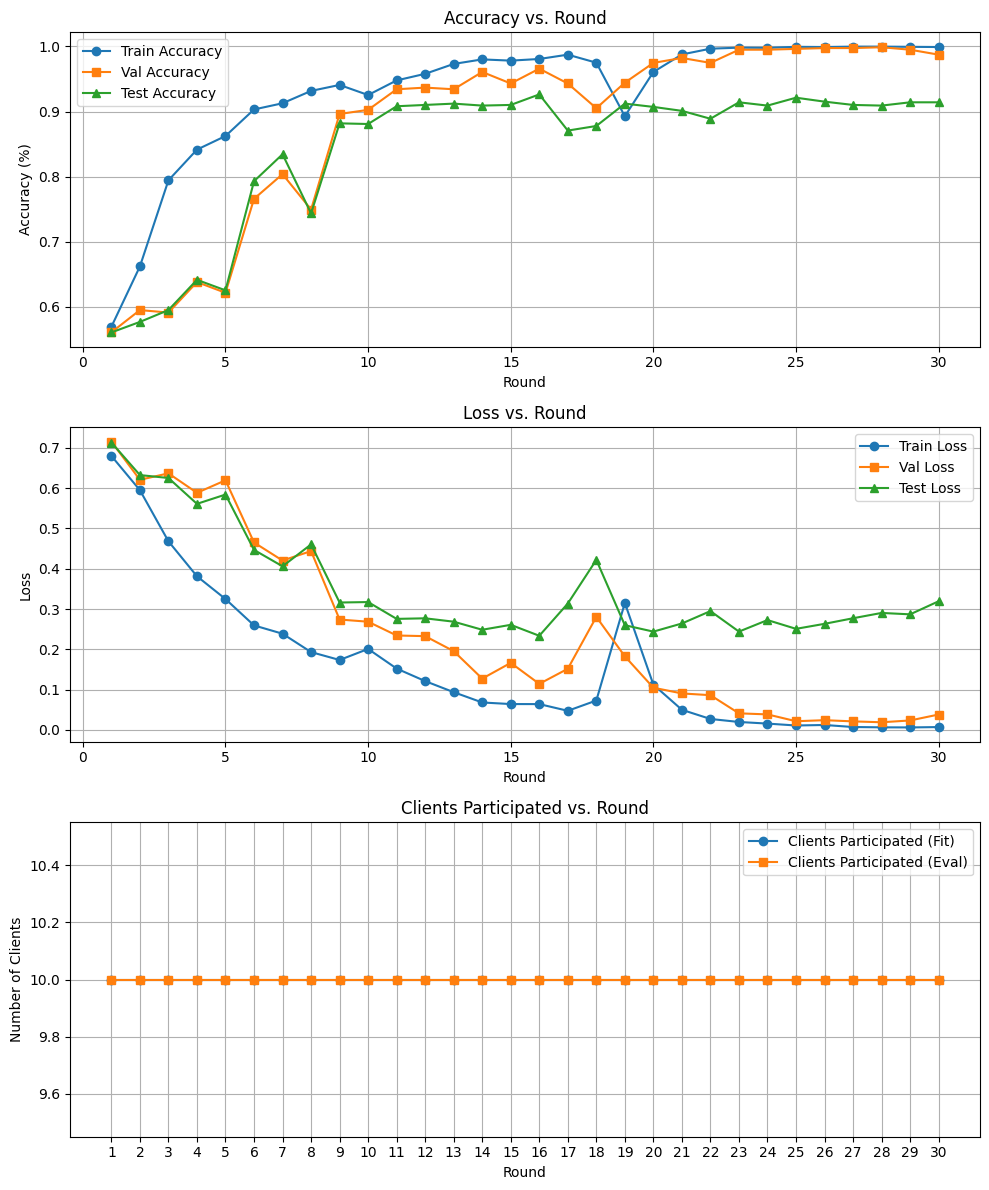

In [34]:
plt.figure(figsize=(10, 12))

# Biểu đồ Accuracy
plt.subplot(3, 1, 1)
plt.plot(range(1, len(HISTORY["train_accuracy"]) + 1), HISTORY["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(HISTORY["val_accuracy"]) + 1), HISTORY["val_accuracy"], label="Val Accuracy", marker='s')
plt.plot(range(1, len(HISTORY["test_accuracy"]) + 1), HISTORY["test_accuracy"], label="Test Accuracy", marker='^')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(HISTORY["train_loss"]) + 1), HISTORY["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(HISTORY["val_loss"]) + 1), HISTORY["val_loss"], label="Val Loss", marker='s')
plt.plot(range(1, len(HISTORY["test_loss"]) + 1), HISTORY["test_loss"], label="Test Loss", marker='^')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Clients Participated
plt.subplot(3, 1, 3)
plt.plot(range(1, len(HISTORY["clients_participated_fit"]) + 1), HISTORY["clients_participated_fit"], label="Clients Participated (Fit)", marker='o')
plt.plot(range(1, len(HISTORY["clients_participated_eval"]) + 1), HISTORY["clients_participated_eval"], label="Clients Participated (Eval)", marker='s')
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()
plt.grid(True)
plt.xticks(range(1, max(len(HISTORY["clients_participated_fit"]), len(HISTORY["clients_participated_eval"])) + 1))

plt.tight_layout()